# This notebook will explore the concept of GPT acting like a doctor that gives prescriptions after seeing diagnosis and procedures. This is built on top of the py mimic prescription that chose the correct option

## Imports

In [1]:
import os
import pandas as pd
from datetime import datetime
from pyhealth.datasets import MIMIC3Dataset
from openai import OpenAI

import json
import tqdm as tqdm

In [2]:
from dotenv import load_dotenv

load_dotenv()

MY_ENV_VAR = os.getenv('MY_ENV_VAR')

In [3]:
# check if the environment variable is set
if MY_ENV_VAR is None:
    print('MY_ENV_VAR is not set')
else:
    print(f'MY_ENV_VAR is set!')

MY_ENV_VAR is set!


## Data

In [4]:
from pyhealth.datasets import MIMIC3Dataset

dataset = MIMIC3Dataset(
    root="/Users/home/Professor Zijun Yao Lab/GPT experiment/EHR Data Sample/MIMIC-III/mimic-iii-clinical-database-1.4",
    tables=["DIAGNOSES_ICD", "PROCEDURES_ICD", "PRESCRIPTIONS"],
    code_mapping={"NDC": ("ATC", {"target_kwargs": {"level": 1}})},
)

In [5]:
dataset.stat()


Statistics of base dataset (dev=False):
	- Dataset: MIMIC3Dataset
	- Number of patients: 46520
	- Number of visits: 58976
	- Number of visits per patient: 1.2678
	- Number of events per visit in DIAGNOSES_ICD: 11.0384
	- Number of events per visit in PROCEDURES_ICD: 4.0711
	- Number of events per visit in PRESCRIPTIONS: 87.1287



'\nStatistics of base dataset (dev=False):\n\t- Dataset: MIMIC3Dataset\n\t- Number of patients: 46520\n\t- Number of visits: 58976\n\t- Number of visits per patient: 1.2678\n\t- Number of events per visit in DIAGNOSES_ICD: 11.0384\n\t- Number of events per visit in PROCEDURES_ICD: 4.0711\n\t- Number of events per visit in PRESCRIPTIONS: 87.1287\n'

In [28]:
from pyhealth.medcode import ICD9CM, ICD10CM, CCSCM, ICD9PROC, ICD10PROC, CCSPROC, NDC, RxNorm, ATC
from pyhealth.medcode import CrossMap

# Initialize the necessary conversion classes
icd9cm = ICD9CM()
icd10cm = ICD10CM()
ccscm = CCSCM()

icd9proc = ICD9PROC()
icd10proc = ICD10PROC()
ccsproc = CCSPROC()

ndc = NDC()
rxnorm = RxNorm()
atc = ATC()

In [29]:
def convert_code(code, *mappings):
    """Utility function to convert a code using multiple mappings."""
    for mapping in mappings:
        try:
            if description := mapping.lookup(code):
                return description
        except KeyError:
            continue
    return code  # Return the original code if all mappings fail

## Prompt generation

In [63]:
def generate_prescription_prompt_v15(patient):
    samples = []
    last_visit = None

    # Iterate through all visits to find the last one
    for visit in patient:
        last_visit = visit

    if last_visit is None:
        print(f"Skipping patient {patient.patient_id}: No visits found.")
        return samples  # No visits, skip this patient

    # Get the discharge status from the last visit
    if not hasattr(last_visit, 'discharge_status'):
        return samples  # Skip if no discharge status
    
    # Extract diagnosis codes and convert to descriptions
    conditions = last_visit.get_code_list(table="DIAGNOSES_ICD")
    conditions_desc = [convert_code(code, icd9cm) for code in conditions[:5]]

    # Extract procedure codes (no conversion needed if mapped)
    procedures = last_visit.get_code_list(table="PROCEDURES_ICD")
    procedures_desc = [convert_code(code, icd9proc, icd10proc, ccsproc) for code in procedures[:5]]

    # Extract the pre-mapped ATC Level 1 codes from prescriptions
    atc_codes = last_visit.get_code_list(table="PRESCRIPTIONS")
    
    if not conditions_desc or not procedures_desc or not atc_codes:
        print(f"Skipping patient {patient.patient_id}: No valid data found.")
        return samples  # Skip if no valid data

    # Create the prompt (without passing prescription details)
    prompt = f"""
    You are a medical expert with knowledge of patients' diagnoses, procedures, and the ATC classification system. Based on the following patient information, provide exactly **10 ATC code** suggestions for appropriate medications. You will select the codes from the following ATC Level 1 categories:

    - A: Alimentary tract and metabolism
    - B: Blood and blood-forming organs
    - C: Cardiovascular system
    - D: Dermatologicals
    - G: Genito-urinary system and sex hormones
    - H: Systemic hormonal preparations, excluding sex hormones and insulins
    - J: Antiinfectives for systemic use
    - L: Antineoplastic and immunomodulating agents
    - M: Musculo-skeletal system
    - N: Nervous system
    - P: Antiparasitic products, insecticides, and repellents
    - R: Respiratory system
    - S: Sensory organs
    - V: Various

    **Patient Case Example 1**:
    - Primary Diagnosis: Hypertension, Type 2 diabetes mellitus
    - Procedures: Blood pressure monitoring, Routine blood glucose test
    **Chain of Thought**:
    - Hypertension suggests the need for cardiovascular medications (ATC Category C: Cardiovascular system).
    - Type 2 diabetes mellitus requires treatment for metabolism (ATC Category A: Alimentary tract and metabolism).
    **Conclusion**: Relevant ATC Level 1 codes are C, A.

    **Patient Case Example 2**:
    - Primary Diagnosis: Bacterial pneumonia
    - Procedures: Chest X-ray, Blood culture
    **Chain of Thought**:
    - Bacterial pneumonia indicates the need for anti-infective medications (ATC Category J: Antiinfectives for systemic use).
    - No other conditions are present that require medications from other ATC categories.
    **Conclusion**: Relevant ATC Level 1 code is J.

    **Patient Case Example 3**:
    - Primary Diagnosis: Osteoarthritis, Chronic back pain
    - Procedures: MRI, Physical therapy
    **Chain of Thought**:
    - Osteoarthritis and chronic back pain suggest the need for musculoskeletal medications (ATC Category M: Musculo-skeletal system).
    - No other procedures suggest the need for medications in different categories.
    **Conclusion**: Relevant ATC Level 1 code is M.

    ### New Patient Information:
    - Primary Diagnosis: {conditions_desc}
    - Procedures: {procedures_desc}

    **Chain of Thought**:
    - Based on the diagnosis and procedures, reason through the most appropriate ATC Level 1 codes.
    **Conclusion**: Provide exactly 10 relevant ATC Level 1 codes.

    ### Example Output:
    A, B, C, D, G, H, J, L, M, N
    """

    # Add the sample from the last visit
    sample = {
        "visit_id": last_visit.visit_id,
        "patient_id": patient.patient_id,
        "diagnosis": conditions_desc,
        "procedures": procedures_desc,
        "atc_codes": atc_codes,
        "prompt": prompt.strip()
    }

    samples.append(sample)
    print(f"Patient {patient.patient_id}: Sample generated successfully.")

    return samples

In [64]:
prescription_dataset = dataset.set_task(generate_prescription_prompt_v15)

Generating samples for generate_prescription_prompt_v15:   7%|▋         | 3324/46520 [00:00<00:02, 16717.31it/s]

Patient 10: Sample generated successfully.
Skipping patient 100: No valid data found.
Patient 1000: Sample generated successfully.
Patient 10000: Sample generated successfully.
Skipping patient 10001: No valid data found.
Skipping patient 10002: No valid data found.
Patient 10003: Sample generated successfully.
Patient 10004: Sample generated successfully.
Skipping patient 10005: No valid data found.
Patient 10006: Sample generated successfully.
Patient 10007: Sample generated successfully.
Patient 10008: Sample generated successfully.
Patient 10009: Sample generated successfully.
Patient 1001: Sample generated successfully.
Patient 10010: Sample generated successfully.
Skipping patient 10011: No valid data found.
Patient 10012: Sample generated successfully.
Patient 10013: Sample generated successfully.
Patient 10014: Sample generated successfully.
Patient 10015: Sample generated successfully.
Patient 10016: Sample generated successfully.
Patient 10017: Sample generated successfully.


Generating samples for generate_prescription_prompt_v15:  15%|█▍        | 6749/46520 [00:00<00:02, 16497.40it/s]

Patient 14150: Sample generated successfully.
Skipping patient 14151: No valid data found.
Patient 14152: Sample generated successfully.
Skipping patient 14153: No valid data found.
Patient 14154: Sample generated successfully.
Skipping patient 14155: No valid data found.
Patient 14156: Sample generated successfully.
Patient 14157: Sample generated successfully.
Patient 14158: Sample generated successfully.
Patient 14159: Sample generated successfully.
Patient 14160: Sample generated successfully.
Patient 14161: Sample generated successfully.
Skipping patient 14162: No valid data found.
Skipping patient 14163: No valid data found.
Patient 14164: Sample generated successfully.
Skipping patient 14165: No valid data found.
Skipping patient 14166: No valid data found.
Patient 14167: Sample generated successfully.
Patient 14168: Sample generated successfully.
Patient 14169: Sample generated successfully.
Patient 1417: Sample generated successfully.
Skipping patient 14170: No valid data foun

Generating samples for generate_prescription_prompt_v15:  22%|██▏       | 10017/46520 [00:00<00:02, 15855.72it/s]

Patient 17580: Sample generated successfully.
Patient 17581: Sample generated successfully.
Patient 17582: Sample generated successfully.
Patient 17583: Sample generated successfully.
Patient 17584: Sample generated successfully.
Patient 17585: Sample generated successfully.
Patient 17586: Sample generated successfully.
Skipping patient 17587: No valid data found.
Patient 17588: Sample generated successfully.
Skipping patient 17589: No valid data found.
Patient 1759: Sample generated successfully.
Patient 17591: Sample generated successfully.
Patient 17592: Sample generated successfully.
Patient 17594: Sample generated successfully.
Patient 17595: Sample generated successfully.
Skipping patient 17596: No valid data found.
Patient 17597: Sample generated successfully.
Skipping patient 17598: No valid data found.
Patient 17599: Sample generated successfully.
Patient 176: Sample generated successfully.
Patient 1760: Sample generated successfully.
Patient 17600: Sample generated successful

Generating samples for generate_prescription_prompt_v15:  28%|██▊       | 13151/46520 [00:00<00:02, 14933.87it/s]

Patient 20855: Sample generated successfully.
Skipping patient 20856: No valid data found.
Skipping patient 20857: No valid data found.
Patient 20858: Sample generated successfully.
Skipping patient 20859: No valid data found.
Patient 2086: Sample generated successfully.
Patient 20860: Sample generated successfully.
Skipping patient 20861: No valid data found.
Skipping patient 20862: No valid data found.
Skipping patient 20863: No valid data found.
Skipping patient 20864: No valid data found.
Patient 20865: Sample generated successfully.
Skipping patient 20866: No valid data found.
Patient 20867: Sample generated successfully.
Patient 20868: Sample generated successfully.
Skipping patient 20869: No valid data found.
Patient 2087: Sample generated successfully.
Patient 20870: Sample generated successfully.
Patient 20871: Sample generated successfully.
Skipping patient 20872: No valid data found.
Skipping patient 20873: No valid data found.
Patient 20874: Sample generated successfully.
S

Generating samples for generate_prescription_prompt_v15:  35%|███▍      | 16092/46520 [00:01<00:02, 13683.15it/s]

Skipping patient 2378: No valid data found.
Patient 23780: Sample generated successfully.
Skipping patient 23781: No valid data found.
Patient 23782: Sample generated successfully.
Patient 23783: Sample generated successfully.
Patient 23784: Sample generated successfully.
Skipping patient 23785: No valid data found.
Patient 23786: Sample generated successfully.
Patient 23787: Sample generated successfully.
Patient 23788: Sample generated successfully.
Patient 23789: Sample generated successfully.
Skipping patient 2379: No valid data found.
Patient 23790: Sample generated successfully.
Skipping patient 23791: No valid data found.
Patient 23792: Sample generated successfully.
Skipping patient 23794: No valid data found.
Patient 23795: Sample generated successfully.
Skipping patient 23796: No valid data found.
Patient 23797: Sample generated successfully.
Patient 23798: Sample generated successfully.
Skipping patient 23799: No valid data found.
Patient 238: Sample generated successfully.


Generating samples for generate_prescription_prompt_v15:  41%|████      | 19144/46520 [00:01<00:01, 14147.37it/s]

Patient 2651: Sample generated successfully.
Patient 26510: Sample generated successfully.
Patient 26511: Sample generated successfully.
Patient 26512: Sample generated successfully.
Patient 26513: Sample generated successfully.
Patient 26514: Sample generated successfully.
Patient 26515: Sample generated successfully.
Patient 26516: Sample generated successfully.
Patient 26517: Sample generated successfully.
Patient 26518: Sample generated successfully.
Patient 26519: Sample generated successfully.
Patient 2652: Sample generated successfully.
Patient 26520: Sample generated successfully.
Patient 26521: Sample generated successfully.
Patient 26522: Sample generated successfully.
Patient 26523: Sample generated successfully.
Skipping patient 26524: No valid data found.
Skipping patient 26525: No valid data found.
Skipping patient 26526: No valid data found.
Patient 26527: Sample generated successfully.
Patient 26528: Sample generated successfully.
Patient 26529: Sample generated success

Generating samples for generate_prescription_prompt_v15:  51%|█████     | 23687/46520 [00:01<00:01, 14838.84it/s]

Patient 29512: Sample generated successfully.
Patient 29513: Sample generated successfully.
Patient 29514: Sample generated successfully.
Patient 29515: Sample generated successfully.
Patient 29516: Sample generated successfully.
Skipping patient 29517: No valid data found.
Patient 29518: Sample generated successfully.
Patient 29519: Sample generated successfully.
Patient 2952: Sample generated successfully.
Patient 29520: Sample generated successfully.
Patient 29521: Sample generated successfully.
Patient 29522: Sample generated successfully.
Patient 29524: Sample generated successfully.
Patient 29525: Sample generated successfully.
Patient 29526: Sample generated successfully.
Patient 29527: Sample generated successfully.
Patient 29528: Sample generated successfully.
Patient 29529: Sample generated successfully.
Patient 2953: Sample generated successfully.
Patient 29530: Sample generated successfully.
Patient 29531: Sample generated successfully.
Skipping patient 29532: No valid data

Generating samples for generate_prescription_prompt_v15:  57%|█████▋    | 26578/46520 [00:01<00:01, 12786.81it/s]

Patient 32757: Sample generated successfully.
Patient 32758: Sample generated successfully.
Patient 32759: Sample generated successfully.
Patient 3276: Sample generated successfully.
Skipping patient 32761: No valid data found.
Patient 32762: Sample generated successfully.
Patient 32763: Sample generated successfully.
Skipping patient 32764: No valid data found.
Patient 32765: Sample generated successfully.
Skipping patient 32766: No valid data found.
Skipping patient 32767: No valid data found.
Patient 32768: Sample generated successfully.
Patient 3277: Sample generated successfully.
Patient 32770: Sample generated successfully.
Skipping patient 32771: No valid data found.
Skipping patient 32772: No valid data found.
Patient 32773: Sample generated successfully.
Patient 32774: Sample generated successfully.
Patient 32775: Sample generated successfully.
Skipping patient 32776: No valid data found.
Patient 32777: Sample generated successfully.
Patient 32779: Sample generated successfull

Generating samples for generate_prescription_prompt_v15:  60%|█████▉    | 27880/46520 [00:02<00:01, 10988.59it/s]


Skipping patient 46872: No valid data found.
Patient 46878: Sample generated successfully.
Patient 4688: Sample generated successfully.
Skipping patient 46880: No valid data found.
Patient 46884: Sample generated successfully.
Patient 46889: Sample generated successfully.
Patient 4689: Sample generated successfully.
Patient 469: Sample generated successfully.
Skipping patient 4690: No valid data found.
Skipping patient 46904: No valid data found.
Skipping patient 4691: No valid data found.
Patient 46910: Sample generated successfully.
Patient 46911: Sample generated successfully.
Patient 46915: Sample generated successfully.
Patient 4692: Sample generated successfully.
Patient 46923: Sample generated successfully.
Patient 46926: Sample generated successfully.
Patient 46927: Sample generated successfully.
Patient 4693: Sample generated successfully.
Patient 46934: Sample generated successfully.
Patient 46935: Sample generated successfully.
Patient 46936: Sample generated successfully.


Generating samples for generate_prescription_prompt_v15:  65%|██████▍   | 30117/46520 [00:02<00:01, 10278.77it/s]

Patient 52002: Sample generated successfully.
Skipping patient 52008: No valid data found.
Skipping patient 5201: No valid data found.
Patient 52010: Sample generated successfully.
Patient 52011: Sample generated successfully.
Patient 52012: Sample generated successfully.
Patient 52018: Sample generated successfully.
Patient 52021: Sample generated successfully.
Patient 52026: Sample generated successfully.
Patient 52027: Sample generated successfully.
Skipping patient 5203: No valid data found.
Patient 52034: Sample generated successfully.
Patient 52038: Sample generated successfully.
Patient 52039: Sample generated successfully.
Skipping patient 5204: No valid data found.
Patient 52040: Sample generated successfully.
Skipping patient 52046: No valid data found.
Patient 5205: Sample generated successfully.
Skipping patient 52054: No valid data found.
Patient 52057: Sample generated successfully.
Patient 52058: Sample generated successfully.
Patient 5206: Sample generated successfully.

Generating samples for generate_prescription_prompt_v15:  69%|██████▉   | 32164/46520 [00:02<00:01, 9256.06it/s] 

Patient 5741: Sample generated successfully.
Patient 57412: Sample generated successfully.
Skipping patient 57418: No valid data found.
Patient 5742: Sample generated successfully.
Patient 57425: Sample generated successfully.
Patient 57427: Sample generated successfully.
Patient 5743: Sample generated successfully.
Patient 57436: Sample generated successfully.
Patient 57437: Sample generated successfully.
Patient 5744: Sample generated successfully.
Skipping patient 57443: No valid data found.
Patient 57445: Sample generated successfully.
Patient 57449: Sample generated successfully.
Patient 5745: Sample generated successfully.
Skipping patient 57454: No valid data found.
Skipping patient 5746: No valid data found.
Skipping patient 57460: No valid data found.
Patient 57465: Sample generated successfully.
Patient 57467: Sample generated successfully.
Patient 57468: Sample generated successfully.
Patient 57470: Sample generated successfully.
Patient 57476: Sample generated successfully.

Generating samples for generate_prescription_prompt_v15:  73%|███████▎  | 34012/46520 [00:02<00:01, 8549.86it/s]

Patient 62160: Sample generated successfully.
Patient 62169: Sample generated successfully.
Patient 6217: Sample generated successfully.
Patient 6218: Sample generated successfully.
Patient 62180: Sample generated successfully.
Patient 62181: Sample generated successfully.
Patient 62183: Sample generated successfully.
Patient 62186: Sample generated successfully.
Patient 62187: Sample generated successfully.
Patient 6219: Sample generated successfully.
Patient 62190: Sample generated successfully.
Skipping patient 62194: No valid data found.
Patient 62199: Sample generated successfully.
Patient 622: Sample generated successfully.
Patient 6220: Sample generated successfully.
Patient 62202: Sample generated successfully.
Patient 62204: Sample generated successfully.
Skipping patient 6221: No valid data found.
Patient 62210: Sample generated successfully.
Patient 62212: Sample generated successfully.
Patient 62215: Sample generated successfully.
Patient 6222: Sample generated successfully

Generating samples for generate_prescription_prompt_v15:  77%|███████▋  | 35876/46520 [00:02<00:01, 8906.07it/s]


Patient 67639: Sample generated successfully.
Patient 6764: Sample generated successfully.
Skipping patient 67642: No valid data found.
Patient 67648: Sample generated successfully.
Patient 6765: Sample generated successfully.
Patient 67651: Sample generated successfully.
Patient 67652: Sample generated successfully.
Patient 67653: Sample generated successfully.
Patient 67657: Sample generated successfully.
Patient 67659: Sample generated successfully.
Patient 6766: Sample generated successfully.
Patient 67661: Sample generated successfully.
Patient 6767: Sample generated successfully.
Patient 67673: Sample generated successfully.
Skipping patient 67675: No valid data found.
Skipping patient 67676: No valid data found.
Skipping patient 6768: No valid data found.
Patient 67680: Sample generated successfully.
Patient 67683: Sample generated successfully.
Patient 67684: Sample generated successfully.
Patient 67687: Sample generated successfully.
Patient 67689: Sample generated successful

Generating samples for generate_prescription_prompt_v15:  82%|████████▏ | 38019/46520 [00:03<00:00, 9722.13it/s]

Patient 72978: Sample generated successfully.
Patient 72979: Sample generated successfully.
Patient 7298: Sample generated successfully.
Patient 72980: Sample generated successfully.
Patient 72981: Sample generated successfully.
Patient 72988: Sample generated successfully.
Patient 7299: Sample generated successfully.
Patient 72992: Sample generated successfully.
Patient 72993: Sample generated successfully.
Skipping patient 72997: No valid data found.
Patient 72998: Sample generated successfully.
Patient 72999: Sample generated successfully.
Patient 73: Sample generated successfully.
Patient 730: Sample generated successfully.
Patient 7300: Sample generated successfully.
Patient 73001: Sample generated successfully.
Patient 73008: Sample generated successfully.
Patient 7301: Sample generated successfully.
Patient 73011: Sample generated successfully.
Skipping patient 73012: No valid data found.
Patient 73015: Sample generated successfully.
Patient 73020: Sample generated successfully.

Generating samples for generate_prescription_prompt_v15:  86%|████████▌ | 39928/46520 [00:03<00:00, 8838.42it/s]

Patient 7917: Sample generated successfully.
Patient 79172: Sample generated successfully.
Patient 79174: Sample generated successfully.
Patient 79177: Sample generated successfully.
Patient 79178: Sample generated successfully.
Patient 7918: Sample generated successfully.
Patient 79183: Sample generated successfully.
Patient 79184: Sample generated successfully.
Patient 79188: Sample generated successfully.
Skipping patient 7919: No valid data found.
Patient 79195: Sample generated successfully.
Patient 792: Sample generated successfully.
Patient 7920: Sample generated successfully.
Patient 7921: Sample generated successfully.
Skipping patient 79210: No valid data found.
Patient 79217: Sample generated successfully.
Patient 79222: Sample generated successfully.
Patient 79224: Sample generated successfully.
Patient 79228: Sample generated successfully.
Patient 79229: Sample generated successfully.
Patient 7923: Sample generated successfully.
Patient 79236: Sample generated successfully

Generating samples for generate_prescription_prompt_v15:  90%|█████████ | 42062/46520 [00:03<00:00, 9602.58it/s]

Patient 84310: Sample generated successfully.
Patient 84318: Sample generated successfully.
Skipping patient 84319: No valid data found.
Patient 8432: Sample generated successfully.
Patient 84320: Sample generated successfully.
Patient 84324: Sample generated successfully.
Patient 84329: Sample generated successfully.
Skipping patient 8433: No valid data found.
Skipping patient 84332: No valid data found.
Skipping patient 8434: No valid data found.
Patient 84346: Sample generated successfully.
Patient 84347: Sample generated successfully.
Skipping patient 8435: No valid data found.
Patient 84350: Sample generated successfully.
Patient 84355: Sample generated successfully.
Patient 84359: Sample generated successfully.
Patient 8436: Sample generated successfully.
Skipping patient 84360: No valid data found.
Patient 84362: Sample generated successfully.
Skipping patient 8437: No valid data found.
Patient 84378: Sample generated successfully.
Patient 84382: Sample generated successfully.
S

Generating samples for generate_prescription_prompt_v15:  94%|█████████▍| 43939/46520 [00:03<00:00, 8770.68it/s]

Patient 90026: Sample generated successfully.
Patient 90028: Sample generated successfully.
Skipping patient 9003: No valid data found.
Patient 90032: Sample generated successfully.
Patient 90033: Sample generated successfully.
Patient 90036: Sample generated successfully.
Patient 9004: Sample generated successfully.
Patient 90040: Sample generated successfully.
Patient 90044: Sample generated successfully.
Patient 90045: Sample generated successfully.
Patient 90046: Sample generated successfully.
Patient 90049: Sample generated successfully.
Patient 9005: Sample generated successfully.
Patient 90051: Sample generated successfully.
Patient 90057: Sample generated successfully.
Patient 90061: Sample generated successfully.
Patient 90066: Sample generated successfully.
Patient 90067: Sample generated successfully.
Patient 9007: Sample generated successfully.
Patient 90070: Sample generated successfully.
Patient 90075: Sample generated successfully.
Patient 90078: Sample generated success

Generating samples for generate_prescription_prompt_v15:  98%|█████████▊| 45713/46520 [00:04<00:00, 8307.74it/s]

Patient 95225: Sample generated successfully.
Patient 95227: Sample generated successfully.
Skipping patient 9523: No valid data found.
Skipping patient 95230: No valid data found.
Patient 95235: Sample generated successfully.
Patient 95237: Sample generated successfully.
Patient 95238: Sample generated successfully.
Skipping patient 95239: No valid data found.
Patient 95240: Sample generated successfully.
Patient 95241: Sample generated successfully.
Patient 95247: Sample generated successfully.
Skipping patient 9525: No valid data found.
Patient 95251: Sample generated successfully.
Patient 9526: Sample generated successfully.
Skipping patient 9527: No valid data found.
Patient 95271: Sample generated successfully.
Patient 95273: Sample generated successfully.
Patient 9528: Sample generated successfully.
Patient 95280: Sample generated successfully.
Patient 95282: Sample generated successfully.
Patient 95285: Sample generated successfully.
Patient 95288: Sample generated successfully

Generating samples for generate_prescription_prompt_v15: 100%|██████████| 46520/46520 [00:04<00:00, 11343.86it/s]


Patient 9986: Sample generated successfully.
Skipping patient 99862: No valid data found.
Patient 99863: Sample generated successfully.
Patient 99864: Sample generated successfully.
Patient 99865: Sample generated successfully.
Skipping patient 99868: No valid data found.
Patient 9987: Sample generated successfully.
Patient 99870: Sample generated successfully.
Patient 99872: Sample generated successfully.
Patient 99873: Sample generated successfully.
Patient 9988: Sample generated successfully.
Patient 99880: Sample generated successfully.
Patient 99881: Sample generated successfully.
Patient 99883: Sample generated successfully.
Skipping patient 9989: No valid data found.
Skipping patient 99893: No valid data found.
Patient 99894: Sample generated successfully.
Skipping patient 99897: No valid data found.
Patient 99899: Sample generated successfully.
Patient 999: Sample generated successfully.
Patient 9990: Sample generated successfully.
Patient 99901: Sample generated successfully.


In [65]:
prescription_dataset.stat()

# let us look at the first sample
print(prescription_dataset.samples[0])

Statistics of sample dataset:
	- Dataset: MIMIC3Dataset
	- Task: generate_prescription_prompt_v15
	- Number of samples: 34682
	- Number of patients: 34682
	- Number of visits: 34682
	- Number of visits per patient: 1.0000
	- diagnosis:
		- Number of diagnosis per sample: 4.8516
		- Number of unique diagnosis: 4654
		- Distribution of diagnosis (Top-10): [('Coronary atherosclerosis of native coronary artery', 4954), ('Acute respiratory failure', 4198), ('Unspecified essential hypertension', 4146), ('Acute kidney failure, unspecified', 3807), ('Atrial fibrillation', 3758), ('Congestive heart failure, unspecified', 3340), ('Urinary tract infection, site not specified', 2314), ('Pneumonia, organism unspecified', 2204), ('Acute posthemorrhagic anemia', 2077), ('Unspecified septicemia', 1978)]
	- procedures:
		- Number of procedures per sample: 3.4544
		- Number of unique procedures: 1780
		- Distribution of procedures (Top-10): [('Venous catheterization, not elsewhere classified', 5719), ('

## DF generation

In [66]:
df = pd.DataFrame(prescription_dataset.samples)
df.head()

visit_id patient_id                                          diagnosis  \
0   184167         10  [Single liveborn, born in hospital, delivered ...   
1   143040       1000  [Amyloidosis, Streptococcal septicemia, Other ...   
2   187813      10000  [Acute and subacute necrosis of liver, Alcohol...   
3   144039      10003  [Traumatic hemothorax without mention of open ...   
4   164713      10004  [Other closed skull fracture with subarachnoid...   

                                          procedures  \
0  [Other phototherapy, Parenteral infusion of co...   
1  [Temporary tracheostomy, Injection or infusion...   
2  [Control of hemorrhage, not otherwise specifie...   
3  [Other operations on lung, Other incision of p...   
4  [Temporary tracheostomy, Percutaneous [endosco...   

                              atc_codes  \
0                             [J, V, B]   
1  [A, B, R, J, C, N, V, H, D, G, S, P]   
2           [C, B, J, H, A, R, N, G, V]   
3           [B, N, C, V, J, A, G, H, P]   
4        [V, B, C, N, A, J, S, M, G, R]   

                                              prompt  
0  You are a medical expert with knowledge of pat...  
1  You are a medical expert with knowledge of pat...  
2  You are a medical expert with knowledge of pat...  
3  You are a medical expert with knowledge of pat...  
4  You are a medical expert with knowledge of pat...

In [45]:
df.shape

(34682, 6)

In [46]:
df['procedures'].nunique

<bound method IndexOpsMixin.nunique of 0        [Other phototherapy, Parenteral infusion of co...
1        [Temporary tracheostomy, Injection or infusion...
2        [Control of hemorrhage, not otherwise specifie...
3        [Other operations on lung, Other incision of p...
4        [Temporary tracheostomy, Percutaneous [endosco...
                               ...                        
34677    [Cardiopulmonary resuscitation, not otherwise ...
34678    [Laparoscopic sigmoidectomy, Reopening of rece...
34679    [Other endovascular procedures on other vessel...
34680    [Endovascular implantation of other graft in a...
34681    [Lumbar and lumbosacral fusion of the anterior...
Name: procedures, Length: 34682, dtype: object>

In [47]:
df['prompt'][10]

"You are a medical expert with knowledge of patients' diagnoses, procedures, and the ATC classification system. Based on the following patient information, provide exactly **10 ATC code** suggestions for appropriate medications. You will select the codes from the following ATC Level 1 categories:\n\n    - A: Alimentary tract and metabolism\n    - B: Blood and blood-forming organs\n    - C: Cardiovascular system\n    - D: Dermatologicals\n    - G: Genito-urinary system and sex hormones\n    - H: Systemic hormonal preparations, excluding sex hormones and insulins\n    - J: Antiinfectives for systemic use\n    - L: Antineoplastic and immunomodulating agents\n    - M: Musculo-skeletal system\n    - N: Nervous system\n    - P: Antiparasitic products, insecticides, and repellents\n    - R: Respiratory system\n    - S: Sensory organs\n    - V: Various\n\n    **Patient Case Example 1**:\n    - Primary Diagnosis: Hypertension, Type 2 diabetes mellitus\n    - Procedures: Blood pressure monitorin

## Prompt Generation for batch

In [111]:
def generate_prescription_prompt_v16(batch):
    # Retrieve the necessary data from the batch
    visit_ids = batch['visit_id']
    patient_ids = batch['patient_id']
    diagnosis_list = batch['diagnosis']
    procedures_list = batch['procedures']
    atc_codes_list = batch['atc_codes']
    
    prompts = []
    
    # Iterate over each patient in the batch
    for i in range(len(visit_ids)):
        diagnosis = '\n'.join([f"- {condition}" for condition in diagnosis_list[i]])
        procedures = '\n'.join([f"- {procedure}" for procedure in procedures_list[i]])
        atc = '\n'.join([f"- {drug}" for drug in atc_codes_list[i]])

        # Create the prompt for the last visit of each patient
        prompt = f"""
        You are a medical expert with knowledge of patients' diagnoses, procedures, and the ATC classification system. Based on the following patient information, provide exactly **10 ATC code** suggestions for appropriate medications. You will select the codes from the following ATC Level 1 categories:

        - A: Alimentary tract and metabolism
        - B: Blood and blood-forming organs
        - C: Cardiovascular system
        - D: Dermatologicals
        - G: Genito-urinary system and sex hormones
        - H: Systemic hormonal preparations, excluding sex hormones and insulins
        - J: Antiinfectives for systemic use
        - L: Antineoplastic and immunomodulating agents
        - M: Musculo-skeletal system
        - N: Nervous system
        - P: Antiparasitic products, insecticides, and repellents
        - R: Respiratory system
        - S: Sensory organs
        - V: Various

        **Patient Case Example 1**:
        - Primary Diagnosis: Hypertension, Type 2 diabetes mellitus
        - Procedures: Blood pressure monitoring, Routine blood glucose test
        **Chain of Thought**:
        - Hypertension suggests the need for cardiovascular medications (ATC Category C: Cardiovascular system).
        - Type 2 diabetes mellitus requires treatment for metabolism (ATC Category A: Alimentary tract and metabolism).
        **Conclusion**: Relevant ATC Level 1 codes are C, A.

        **Patient Case Example 2**:
        - Primary Diagnosis: Bacterial pneumonia
        - Procedures: Chest X-ray, Blood culture
        **Chain of Thought**:
        - Bacterial pneumonia indicates the need for anti-infective medications (ATC Category J: Antiinfectives for systemic use).
        - No other conditions are present that require medications from other ATC categories.
        **Conclusion**: Relevant ATC Level 1 code is J.

        **Patient Case Example 3**:
        - Primary Diagnosis: Osteoarthritis, Chronic back pain
        - Procedures: MRI, Physical therapy
        **Chain of Thought**:
        - Osteoarthritis and chronic back pain suggest the need for musculoskeletal medications (ATC Category M: Musculo-skeletal system).
        - No other procedures suggest the need for medications in different categories.
        **Conclusion**: Relevant ATC Level 1 code is M.

        **Patient Information**:
        - Primary Diagnosis: {diagnosis}
        - Procedures: {procedures}
        - Atc Codes: {atc}

        **Chain of Thought**:
        - Based on the diagnosis and procedures, reason through the most appropriate ATC Level 1 codes.
        **Conclusion**: You must provide the most relevant ATC Level 1 codes.

        ### Example Output:
        A, B, C, D, G, L, M, N
        """
        
        prompts.append(prompt.strip())
    
    return prompts

## Dataloader generation

In [112]:
from pyhealth.datasets.splitter import split_by_patient
from pyhealth.datasets import split_by_patient, get_dataloader

# data split
train_dataset, valtest_dataset,test_dataset = split_by_patient(prescription_dataset, [0.60, 0.20, 0.20])

# create dataloaders (they are <torch.data.DataLoader> object)
train_loader = get_dataloader(train_dataset, batch_size=64, shuffle=True)
val_loader = get_dataloader(valtest_dataset, batch_size=64, shuffle=False)
test_loader = get_dataloader(test_dataset, batch_size=64, shuffle=False)

In [113]:
# Fetch the first batch from the test loader to inspect its structure
first_batch = next(iter(test_loader))

# Inspect what the first batch contains
print(type(first_batch))
print(first_batch.keys())  # If it's a dictionary
print(first_batch)  # Print to inspect the content

<class 'dict'>
dict_keys(['visit_id', 'patient_id', 'diagnosis', 'procedures', 'atc_codes', 'prompt'])
{'visit_id': ['126100', '158046', '177923', '142012', '177188', '127380', '190445', '172475', '136523', '143867', '145520', '157868', '113788', '100662', '123882', '165706', '105602', '174797', '153545', '158300', '175657', '144898', '137690', '105682', '126929', '170802', '142004', '185846', '178844', '163736', '183943', '115693', '104936', '160002', '186754', '109056', '126988', '172500', '171592', '176981', '165629', '182743', '178705', '132359', '141446', '105411', '111251', '190668', '106146', '148901', '133692', '185305', '165036', '132974', '165589', '169523', '194984', '131278', '179114', '127353', '114635', '198161', '134671', '110911'], 'patient_id': ['76097', '7974', '10387', '4194', '12881', '99894', '55051', '69693', '20730', '17828', '6219', '41269', '54662', '14934', '63785', '26869', '28580', '13116', '29419', '31781', '63616', '49359', '84107', '6734', '40582', '85895

In [114]:
all_prompts = []
for batch in test_loader:
    prompts = generate_prescription_prompt_v16(batch)
    all_prompts.extend(prompts)

# Optionally: Print the first prompt for review
print(all_prompts[200])

You are a medical expert with knowledge of patients' diagnoses, procedures, and the ATC classification system. Based on the following patient information, provide exactly **10 ATC code** suggestions for appropriate medications. You will select the codes from the following ATC Level 1 categories:

        - A: Alimentary tract and metabolism
        - B: Blood and blood-forming organs
        - C: Cardiovascular system
        - D: Dermatologicals
        - G: Genito-urinary system and sex hormones
        - H: Systemic hormonal preparations, excluding sex hormones and insulins
        - J: Antiinfectives for systemic use
        - L: Antineoplastic and immunomodulating agents
        - M: Musculo-skeletal system
        - N: Nervous system
        - P: Antiparasitic products, insecticides, and repellents
        - R: Respiratory system
        - S: Sensory organs
        - V: Various

        **Patient Case Example 1**:
        - Primary Diagnosis: Hypertension, Type 2 diabetes mellitu

## GPT Call

In [102]:
client = OpenAI(api_key=os.environ.get("MY_ENV_VAR"),)

In [103]:
# Define the function for passing the prompt to GPT
def get_suggested_prescription(prompt):
    system_message = {
        "role": "system",
        "content": (
            "You are a medical expert with extensive knowledge of diagnoses, procedures, and the ATC classification system. "
            "Your task is to suggest exactly 10 ATC Level 1 codes based only on the given diagnosis and procedures. "
            "You should provide only the ATC codes without explanations or any additional information."
        )
    }   

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            system_message,
            {"role": "user", "content": prompt}
        ],
        max_tokens=50,  # Adjust tokens based on expected prescription response
        temperature=0.1  # Adjust temperature to control the deterministic response
    )
    
    return response.choices[0].message.content.strip()

In [104]:
prompts = df['prompt'].iloc[:500].tolist()

prompts

["You are a medical expert with knowledge of patients' diagnoses, procedures, and the ATC classification system. Based on the following patient information, provide exactly **10 ATC code** suggestions for appropriate medications. You will select the codes from the following ATC Level 1 categories:\n\n    - A: Alimentary tract and metabolism\n    - B: Blood and blood-forming organs\n    - C: Cardiovascular system\n    - D: Dermatologicals\n    - G: Genito-urinary system and sex hormones\n    - H: Systemic hormonal preparations, excluding sex hormones and insulins\n    - J: Antiinfectives for systemic use\n    - L: Antineoplastic and immunomodulating agents\n    - M: Musculo-skeletal system\n    - N: Nervous system\n    - P: Antiparasitic products, insecticides, and repellents\n    - R: Respiratory system\n    - S: Sensory organs\n    - V: Various\n\n    **Patient Case Example 1**:\n    - Primary Diagnosis: Hypertension, Type 2 diabetes mellitus\n    - Procedures: Blood pressure monitori

In [115]:
pd.DataFrame(prompts).to_csv('prompts_ask_prescriptions_atc_codes.csv')

In [116]:
# subset 2000 prompts from all_prompts

prompts_2k = all_prompts[:2000]

In [117]:
# Store predictions
predictions = []

# Pass each prompt to ChatGPT and get a prediction
for prompt in prompts_2k:
    prediction = get_suggested_prescription(prompt)  # Assuming the `get_prediction` function is already defined
    predictions.append(prgediction)

In [118]:
# read the first prediction
predictions[0]

'N, C, J, R, A, V, S, H, B, P'

In [119]:
predictions[1]

'J, B, N, R, A, V, M, P, C, D'

In [120]:
predictions[2]

'C, G, A, N, B, J'

In [121]:
# taking the first 500 predictions and appending as a column to the dataframe
# true_500_atc_labels = df['atc_codes'].iloc[:500].tolist()

In [122]:
# # now creating a new df with the predictions and the true labels
# df_500 = pd.DataFrame({'prompt': prompts, 'predictions': predictions, 'true_atc_codes': true_500_atc_labels})

# df_500.head()

## Test Loader DF

In [124]:
first_batch = next(iter(test_loader))

# Inspect what the first batch contains
print(type(first_batch))
print(first_batch.keys())  # If it's a dictionary
print(first_batch)  # Print to inspect the content

<class 'dict'>
dict_keys(['visit_id', 'patient_id', 'diagnosis', 'procedures', 'atc_codes', 'prompt'])
{'visit_id': ['126100', '158046', '177923', '142012', '177188', '127380', '190445', '172475', '136523', '143867', '145520', '157868', '113788', '100662', '123882', '165706', '105602', '174797', '153545', '158300', '175657', '144898', '137690', '105682', '126929', '170802', '142004', '185846', '178844', '163736', '183943', '115693', '104936', '160002', '186754', '109056', '126988', '172500', '171592', '176981', '165629', '182743', '178705', '132359', '141446', '105411', '111251', '190668', '106146', '148901', '133692', '185305', '165036', '132974', '165589', '169523', '194984', '131278', '179114', '127353', '114635', '198161', '134671', '110911'], 'patient_id': ['76097', '7974', '10387', '4194', '12881', '99894', '55051', '69693', '20730', '17828', '6219', '41269', '54662', '14934', '63785', '26869', '28580', '13116', '29419', '31781', '63616', '49359', '84107', '6734', '40582', '85895

In [142]:
data = []

for batch in test_loader:
    # Extract visit_id, patient_id, diagnosis, procedures, atc_codes, and prompts
    visit_ids = batch['visit_id']
    patient_ids = batch['patient_id']
    diagnosis_list = batch['diagnosis']
    procedures_list = batch['procedures']
    atc_codes_list = batch['atc_codes']
    prompts = batch['prompt']

    # Append each patient's data to the list
    for i in range(len(visit_ids)):
        data.append({
            'visit_id': visit_ids[i],
            'patient_id': patient_ids[i],
            'conditions': diagnosis_list[i],
            'procedures': procedures_list[i],
            'atc_codes': atc_codes_list[i],
            'prompt': prompts[i],
            'gpt_predictions': predictions[i]
        })


In [146]:
df_test = pd.DataFrame(data)

# Display the DataFrame with predictions
df_test.head()

visit_id patient_id                                         conditions  \
0   126100      76097  [Occlusion and stenosis of multiple and bilate...   
1   158046       7974  [Persistent postoperative fistula, Cerebrospin...   
2   177923      10387  [Coronary atherosclerosis of native coronary a...   
3   142012       4194  [Coronary atherosclerosis of native coronary a...   
4   177188      12881  [Down's syndrome, Ostium secundum type atrial ...   

                                          procedures  \
0  [Percutaneous angioplasty of extracranial vess...   
1  [Other repair of cerebral meninges, Other expl...   
2  [(Aorto)coronary bypass of two coronary arteri...   
3  [Single internal mammary-coronary artery bypas...   
4  [Prophylactic administration of vaccine agains...   

                        atc_codes  \
0           [B, A, V, N, C, J, R]   
1  [J, B, N, R, A, V, M, P, C, D]   
2           [G, V, A, N, C, J, B]   
3     [N, A, C, G, M, B, J, V, R]   
4                       [J, B, V]   

                                              prompt  \
0  You are a medical expert with knowledge of pat...   
1  You are a medical expert with knowledge of pat...   
2  You are a medical expert with knowledge of pat...   
3  You are a medical expert with knowledge of pat...   
4  You are a medical expert with knowledge of pat...   

                gpt_predictions  
0  N, C, J, R, A, V, S, H, B, P  
1  J, B, N, R, A, V, M, P, C, D  
2              C, G, A, N, B, J  
3              C, A, G, M, R, V  
4  J, A, B, G, V, H, P, S, R, N

## Metrics

In [147]:
from sklearn.preprocessing import MultiLabelBinarizer
from pyhealth.metrics.multilabel import multilabel_metrics_fn

# Create a set of all ATC Level 1 codes
all_atc_codes = ['A', 'B', 'C', 'D', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'V']

# Initialize the binarizer
mlb = MultiLabelBinarizer(classes=all_atc_codes)

# Binarize true ATC codes and predictions
y_true_bin = mlb.fit_transform(df_test['atc_codes'])
y_pred_bin = mlb.transform(df_test['gpt_predictions'])

# Calculate metrics using the multilabel_metrics_fn
metrics = multilabel_metrics_fn(y_true_bin, y_pred_bin, metrics=["pr_auc_samples","f1_weighted", "pr_auc_weighted"])

# Output the calculated metrics
print(metrics)

{'pr_auc_samples': 0.6888918016417297, 'f1_weighted': 0.734862966256461, 'pr_auc_weighted': 0.7480244401674585}


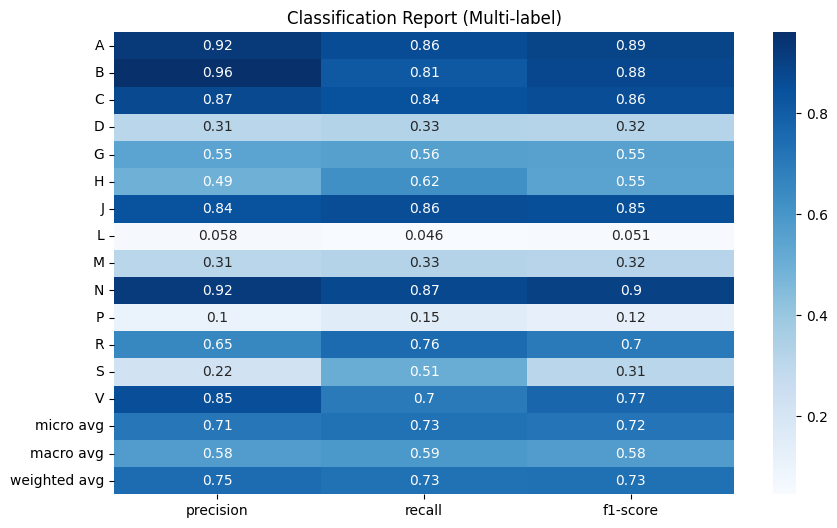

In [148]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Classification Report Plot
from sklearn.metrics import classification_report

y_pred_labels = y_pred_bin  # Binarized predictions
y_true_labels = y_true_bin  # Binarized true labels

# Generate classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=all_atc_codes, output_dict=True)

report_df = pd.DataFrame(report).transpose()

# Plot classification report as heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Blues")
plt.title("Classification Report (Multi-label)")
plt.show()

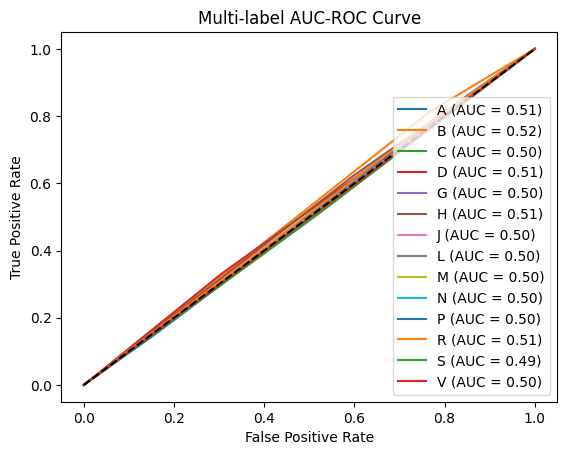

In [149]:
for i, atc in enumerate(all_atc_codes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    auc = roc_auc_score(y_true_bin[:, i], y_pred_bin[:, i])
    plt.plot(fpr, tpr, label=f'{atc} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-label AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()

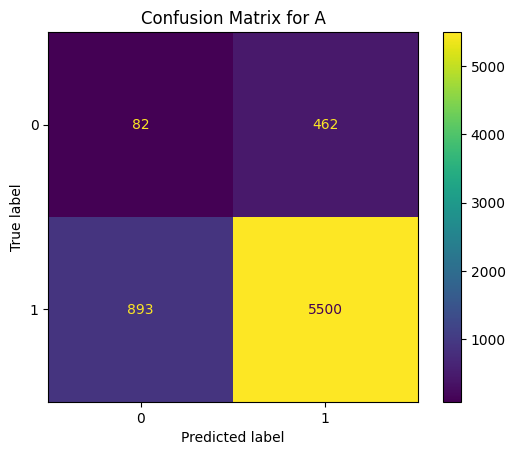

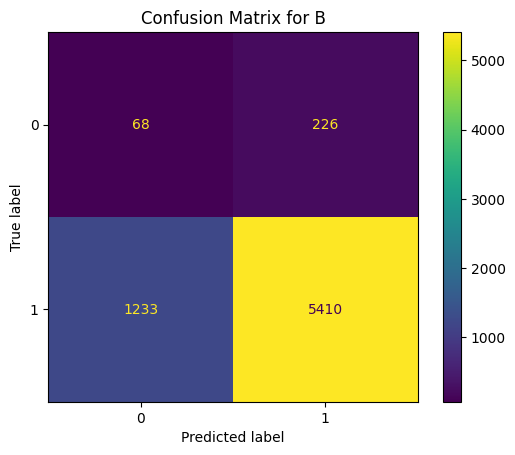

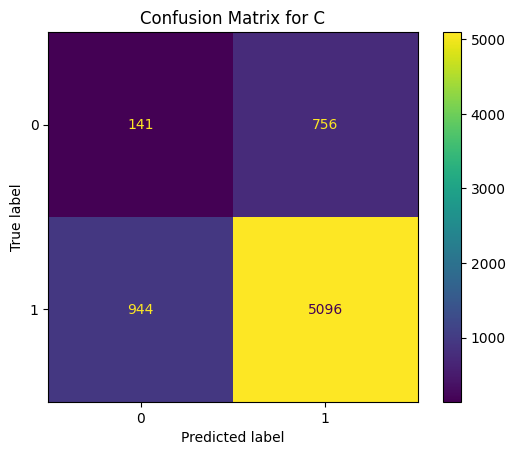

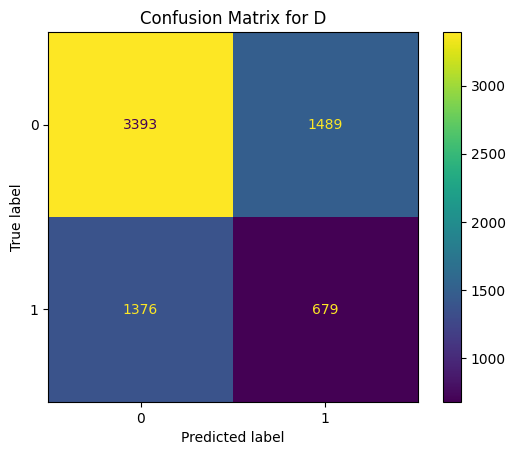

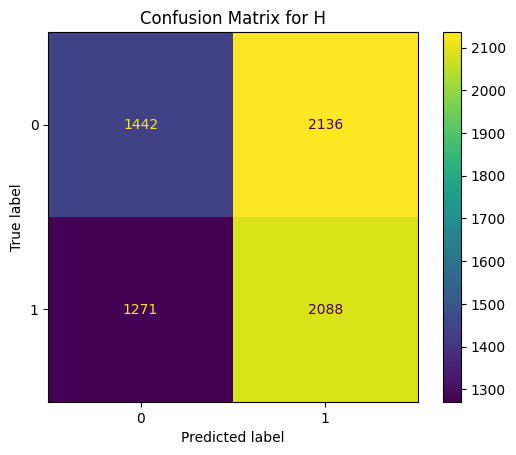

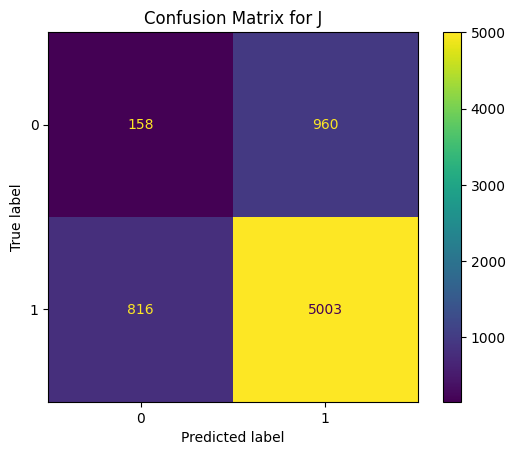

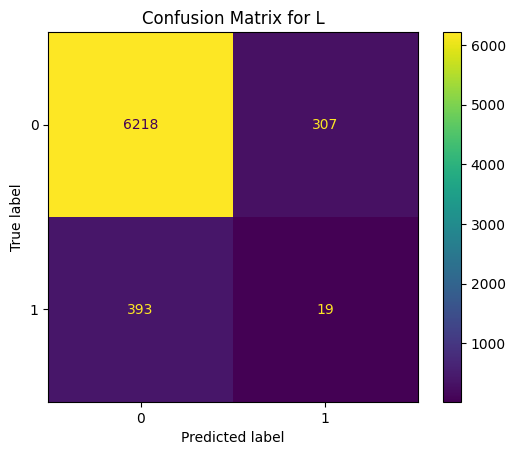

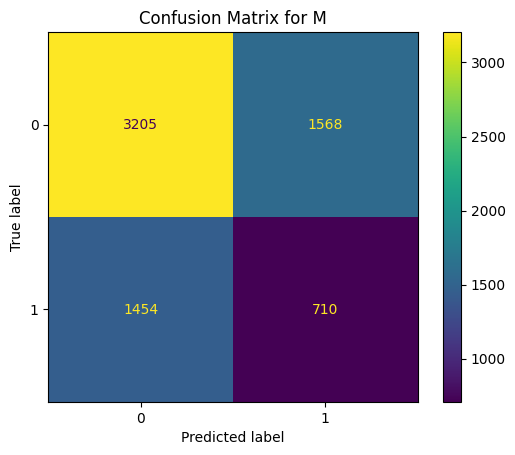

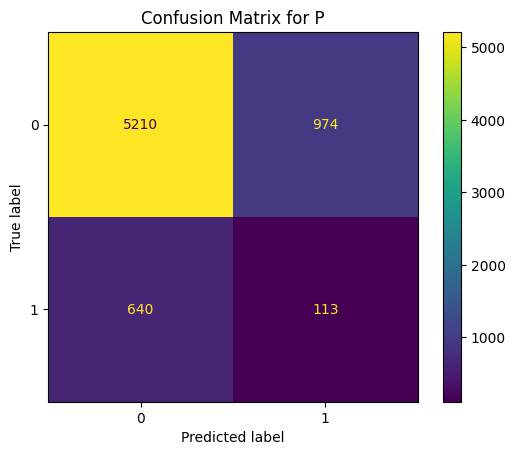

In [150]:
cm = multilabel_confusion_matrix(y_true_bin, y_pred_bin, labels=range(len(all_atc_codes)))

# Plot confusion matrix for each ATC code
for i, atc in enumerate(all_atc_codes):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm[i])
    disp.plot()
    plt.title(f'Confusion Matrix for {atc}')
    plt.show()

## Model - Pyhealth : Compare with GPT

In [151]:
print(prescription_dataset.input_info.keys())

dict_keys(['visit_id', 'patient_id', 'diagnosis', 'procedures', 'atc_codes', 'prompt'])


In [153]:
import pyhealth
from pyhealth.models import Transformer, RETAIN, GAMENet, MICRON
from pyhealth.trainer import Trainer
from pyhealth.metrics.multilabel import multilabel_metrics_fn

# function to train and evaluate models
def evaluate_models(model_names, dataset, train_loader, val_loader, test_loader):
    for model_name in model_names:
        print(f"Evaluating model: {model_name}")
        
        # Retrieve the model class from pyhealth.models dynamically
        model_class = getattr(pyhealth.models, model_name)
        
        # Initialize the model with the given dataset
        model = model_class(
            dataset=dataset,
            feature_keys=["diagnosis", "procedures"],
            label_key="atc_codes",
            mode="multilabel",
        )
        
        # Initialize the Trainer object
        trainer = Trainer(model=model)
        
        # Train the model
        trainer.train(
            train_dataloader=train_loader,
            val_dataloader=val_loader,
            epochs=3,  # Adjust as needed
            monitor="pr_auc_samples",
        )
        
        # Evaluate the model using built-in evaluation
        test_score = trainer.evaluate(test_loader)
        print(f"Built-in evaluation score for {model_name}: {test_score}")
        
        # Custom evaluation using pyhealth metrics
        y_true, y_prob, loss = trainer.inference(test_loader)
        custom_metrics = multilabel_metrics_fn(y_true, y_prob, metrics=["pr_auc_samples", "f1_weighted", "pr_auc_weighted"])
        print(f"Custom evaluation metrics for {model_name}: {custom_metrics}")

# List of model names to evaluate
model_name_list = ['Transformer', 'RETAIN', 'MICRON']

# Example usage
evaluate_models(model_name_list, prescription_dataset, train_loader, val_loader, test_loader)

Evaluating model: Transformer
Transformer(
  (embeddings): ModuleDict(
    (diagnosis): Embedding(4656, 128, padding_idx=0)
    (procedures): Embedding(1782, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (diagnosis): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0-2): 3 x Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in_features=512, out_features=128, bias=True)
            (dropout): Dropout(p=0.5, inplace=False)
            (activation): GELU(approximate='no

Epoch 0 / 3: 100%|██████████| 326/326 [00:06<00:00, 50.74it/s]

--- Train epoch-0, step-326 ---
loss: 0.3958



Evaluation: 100%|██████████| 109/109 [00:00<00:00, 151.54it/s]


--- Eval epoch-0, step-326 ---
pr_auc_samples: 0.9569
loss: 0.3425
New best pr_auc_samples score (0.9569) at epoch-0, step-326



Epoch 1 / 3: 100%|██████████| 326/326 [00:05<00:00, 56.09it/s]

--- Train epoch-1, step-652 ---
loss: 0.3501



Evaluation: 100%|██████████| 109/109 [00:00<00:00, 173.62it/s]


--- Eval epoch-1, step-652 ---
pr_auc_samples: 0.9566
loss: 0.3371



Epoch 2 / 3: 100%|██████████| 326/326 [00:06<00:00, 53.72it/s]

--- Train epoch-2, step-978 ---
loss: 0.3406



Evaluation: 100%|██████████| 109/109 [00:00<00:00, 172.49it/s]


--- Eval epoch-2, step-978 ---
pr_auc_samples: 0.9564
loss: 0.3320
Loaded best model


Evaluation: 100%|██████████| 109/109 [00:00<00:00, 170.40it/s]


Built-in evaluation score for Transformer: {'pr_auc_samples': 0.9571015974423461, 'loss': 0.3434969383642214}


Evaluation: 100%|██████████| 109/109 [00:00<00:00, 183.19it/s]


Custom evaluation metrics for Transformer: {'pr_auc_samples': 0.9571015974423461, 'f1_weighted': 0.8609706067290112, 'pr_auc_weighted': 0.8812262097363813}
Evaluating model: RETAIN
RETAIN(
  (embeddings): ModuleDict(
    (diagnosis): Embedding(4656, 128, padding_idx=0)
    (procedures): Embedding(1782, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (retain): ModuleDict(
    (diagnosis): RETAINLayer(
      (dropout_layer): Dropout(p=0.5, inplace=False)
      (alpha_gru): GRU(128, 128, batch_first=True)
      (beta_gru): GRU(128, 128, batch_first=True)
      (alpha_li): Linear(in_features=128, out_features=1, bias=True)
      (beta_li): Linear(in_features=128, out_features=128, bias=True)
    )
    (procedures): RETAINLayer(
      (dropout_layer): Dropout(p=0.5, inplace=False)
      (alpha_gru): GRU(128, 128, batch_first=True)
      (beta_gru): GRU(128, 128, batch_first=True)
      (alpha_li): Linear(in_features=128, out_features=1, bias=True)
      (beta_li): Linear(in_featur

Epoch 0 / 3: 100%|██████████| 326/326 [00:12<00:00, 25.72it/s]

--- Train epoch-0, step-326 ---
loss: 0.4322



Evaluation: 100%|██████████| 109/109 [00:01<00:00, 104.76it/s]


--- Eval epoch-0, step-326 ---
pr_auc_samples: 0.9542
loss: 0.3612
New best pr_auc_samples score (0.9542) at epoch-0, step-326



Epoch 1 / 3: 100%|██████████| 326/326 [00:13<00:00, 24.57it/s]

--- Train epoch-1, step-652 ---
loss: 0.3563



Evaluation: 100%|██████████| 109/109 [00:01<00:00, 97.86it/s]


--- Eval epoch-1, step-652 ---
pr_auc_samples: 0.9563
loss: 0.3476
New best pr_auc_samples score (0.9563) at epoch-1, step-652



Epoch 2 / 3: 100%|██████████| 326/326 [00:13<00:00, 24.67it/s]

--- Train epoch-2, step-978 ---
loss: 0.3448



Evaluation: 100%|██████████| 109/109 [00:01<00:00, 93.27it/s]


--- Eval epoch-2, step-978 ---
pr_auc_samples: 0.9577
loss: 0.3409
New best pr_auc_samples score (0.9577) at epoch-2, step-978
Loaded best model


Evaluation: 100%|██████████| 109/109 [00:01<00:00, 91.36it/s]


Built-in evaluation score for RETAIN: {'pr_auc_samples': 0.957454347984046, 'loss': 0.34105448957976947}


Evaluation: 100%|██████████| 109/109 [00:01<00:00, 107.93it/s]


Custom evaluation metrics for RETAIN: {'pr_auc_samples': 0.957454347984046, 'f1_weighted': 0.8631543184348356, 'pr_auc_weighted': 0.8854730277431674}
Evaluating model: MICRON


KeyError: 'conditions'